In [2]:
from IPython.display import Audio
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

fs, modulator = wavfile.read('modulator.wav')
fs1, carrier = wavfile.read('organ_carrier.wav')
print(modulator.shape, carrier.shape)
print(f"fs: {fs}, fs1: {fs1}")


carrier = carrier[:min(len(modulator), len(carrier))]
modulator = modulator[:min(len(modulator), len(carrier))]

print(len(carrier))
print(len(modulator))

Audio(modulator, rate=fs)

(49134,) (70562,)
fs: 22050, fs1: 22050
49134
49134


In [3]:
def get_hamming(x):
    return [0.54 - (0.46*np.cos(2*np.pi*n/N)) for n in range(len(x))]

def get_stft(signal, L, delta_m, window_fn=None):
    """
    :param signal: time-sampled signal
    :param L: window size per DFT in samples
    :param delta_m: how many samples the window is moved 
    :param conv: convolution function for signal
    
    :return L x ms matrix where each column is a single dft frame 
    """
    N = len(signal)
    ms = np.arange(0, N-L, delta_m)
    dfts = None
    for m in ms:
        window = signal[m:m+L]
        if window_fn:
            window = window * window_fn
        freq_window = np.array([np.fft.fft(window)]).T
        dfts = freq_window if dfts is None else np.hstack([
            dfts, 
            freq_window
        ])
    return ms, dfts

def get_istft(stft, delta_m, window_fn=None):
    L = stft.shape[0]
    signal = np.array([])
    m = delta_m
    for col in range(stft.shape[1]):
        signal_window = np.fft.ifft(stft[:, col])
        if col % 100 == 0:
            print(m)
            print(signal_window.shape)
        if window_fn:
            signal_window = signal_window / window_fn
        signal = np.concatenate([
            signal[:m],
            signal_window
        ])
        m += delta_m
    return signal * (1/L)

def get_cepstral_envs(stft):
    cepstral_envs = None
    L = stft.shape[0]
    # TODO: this needs to be made symmetrical about fs/2 Nyquist
    # E.g.       [-1-, -2-, 3, 4, 5 | 5, 4, 3, -2-, -1-]
    w = np.concatenate([np.ones(L//16), np.zeros(15*L//16)])  
    for col in range(stft.shape[1]):
        spectrum_window = stft[:, col]
        env = np.fft.fft(w * np.fft.ifft(np.log10(np.abs(spectrum_window)+1)).real).real
        env = np.array([env]).T
#         spectral_envelope = spectral_envelope - np.mean(spectral_envelope)
        cepstral_envs = env if cepstral_envs is None else np.hstack([
            cepstral_envs, 
            env
        ])
    return cepstral_envs

def spectral_flatten(stft):
    cepstral_envs = get_cepstral_envs(stft)
    return stft / cepstral_envs
#     flat_stft = None
#     for col in range(stft.shape[1]):
#         spectrum_window = stft[:, col]
#         env = cepstral_envs[:, col]
#         flat = np.array([spectrum_window / env]).T
#         flat_stft = flat if flat_stft is None else np.hstack([
#             flat_stft,
#             flat
#         ])
#     return flat_stft

def cross_synthesize(carrier, modulator, L, delta_m, window_fn=None):
    """
    :param carrier: 
    """
    ms, carrier_stft = get_stft(carrier, L, delta_m, window_fn)
    _, modulator_stft = get_stft(modulator, L, delta_m, window_fn)
    
    flat_carrier_stft = spectral_flatten(carrier_stft)
    modulator_envs = get_cepstral_envs(modulator_stft)
    
    cross_synth_stft = flat_carrier_stft * modulator_envs
#     frame_count = min(carrier_stft.shape[1], modulator_stft.shape[1])
#     for frame in range(frame_count):
#         cross_frame = flat_carrier_stft[:, frame] * modulator_envs[:, frame]
#         cross_frame = np.array([cross_frame]).T
#         cross_synth_stft = cross_frame if cross_synth_stft is None else np.hstack([
#             cross_synth_stft,
#             cross_frame
#         ])
    
    return ms, cross_synth_stft, get_istft(cross_synth_stft, delta_m, window_fn)        
    
    
def plot_spectrogram(ms, stft, fs, colorbar=False):    
    plt.figure(figsize=[40,40])
    L = stft.shape[0]
    # we only look at DFT freq up to nyquist limit fs/2, and normalize out imag components
    stft_db = 20*np.log10(np.abs(stft[:L//2, :])*2)
    plt_spec = plt.imshow(
        stft_db,
        origin='lower'
    )
    
    ## create ylim
    num_yticks = 10
    ks = np.linspace(0, L/2, num_yticks)
    ks_hz = ks * fs // (L)
    plt.yticks(ks,ks_hz)
    plt.ylabel("Frequency (Hz)")

    ## create xlim
    num_xticks = 10
    ts_spec = np.linspace(0, len(ms), num_xticks)
    ts_spec_sec  = ["{:4.2f}".format(i) for i in np.linspace(0, ms[-1]/fs, num_xticks)]
    plt.xticks(ts_spec,ts_spec_sec)
    plt.xlabel("Time (sec)")

    plt.title(f"Spectrogram L={L} delta_m={delta_m}, fs={fs} Spectrogram.shape={stft.shape}")
    if colorbar:
        plt.colorbar(None, use_gridspec=True)
    plt.show()
    return(plt_spec)


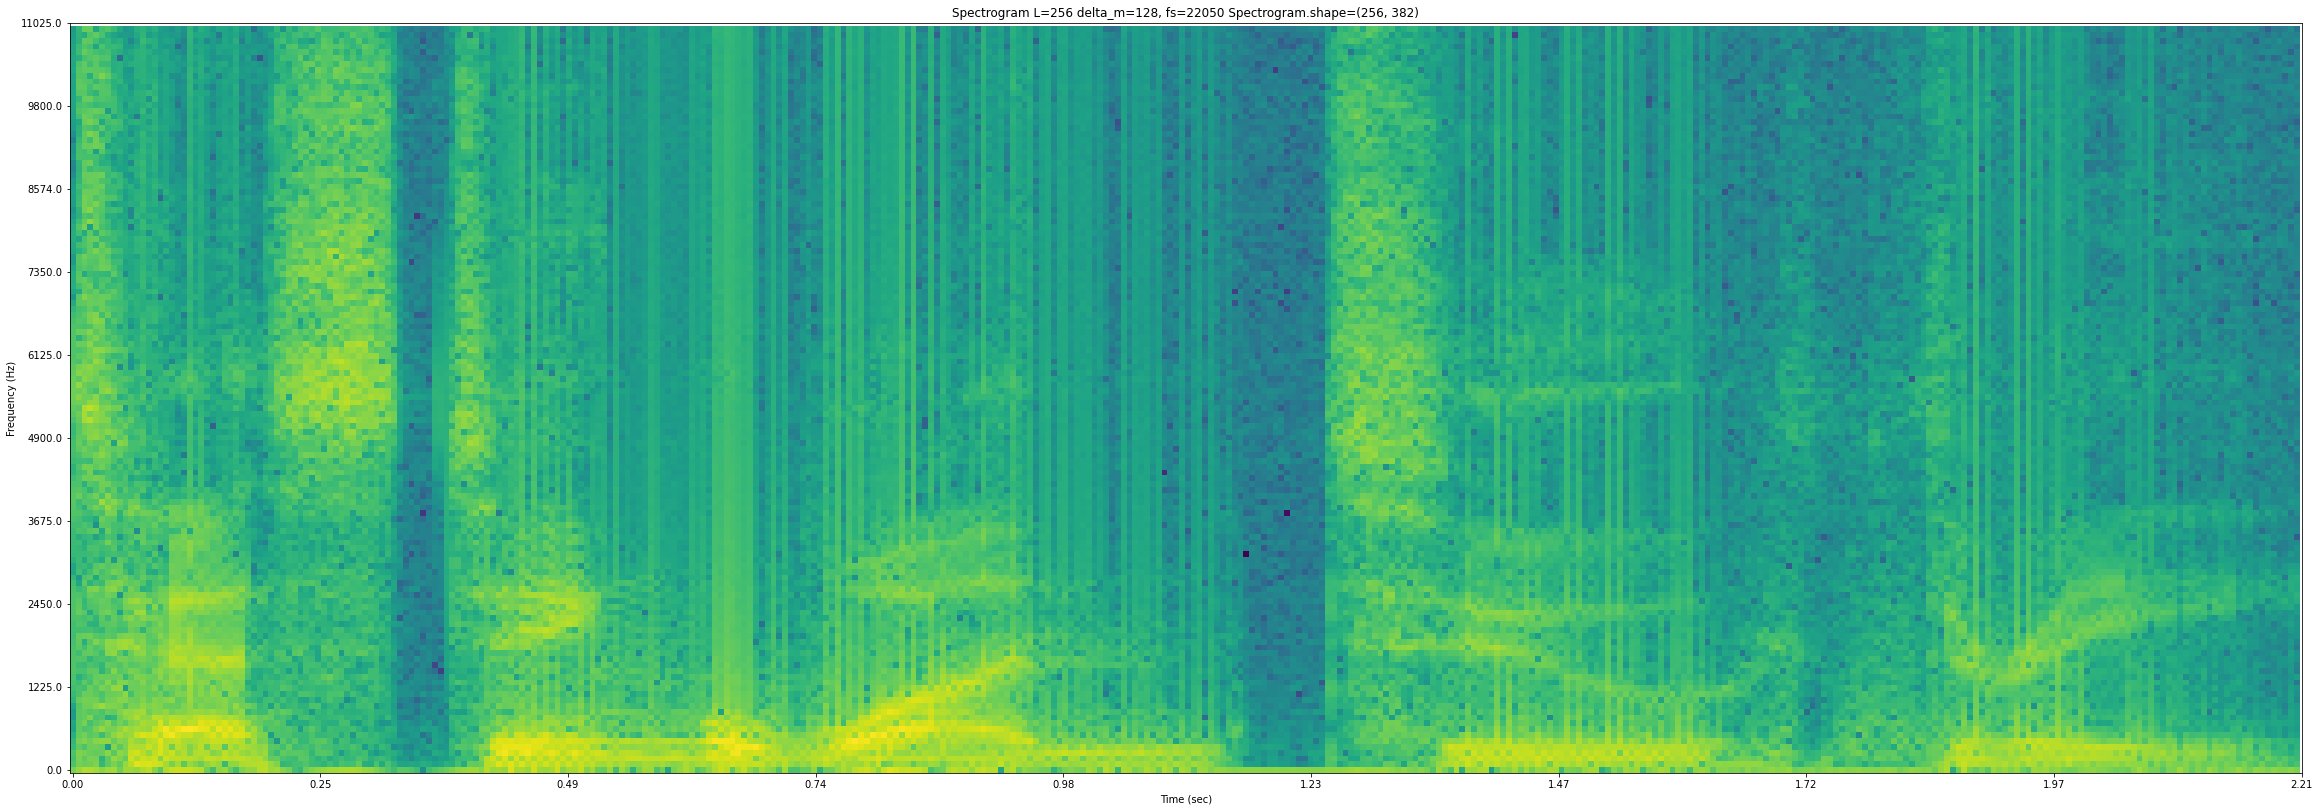

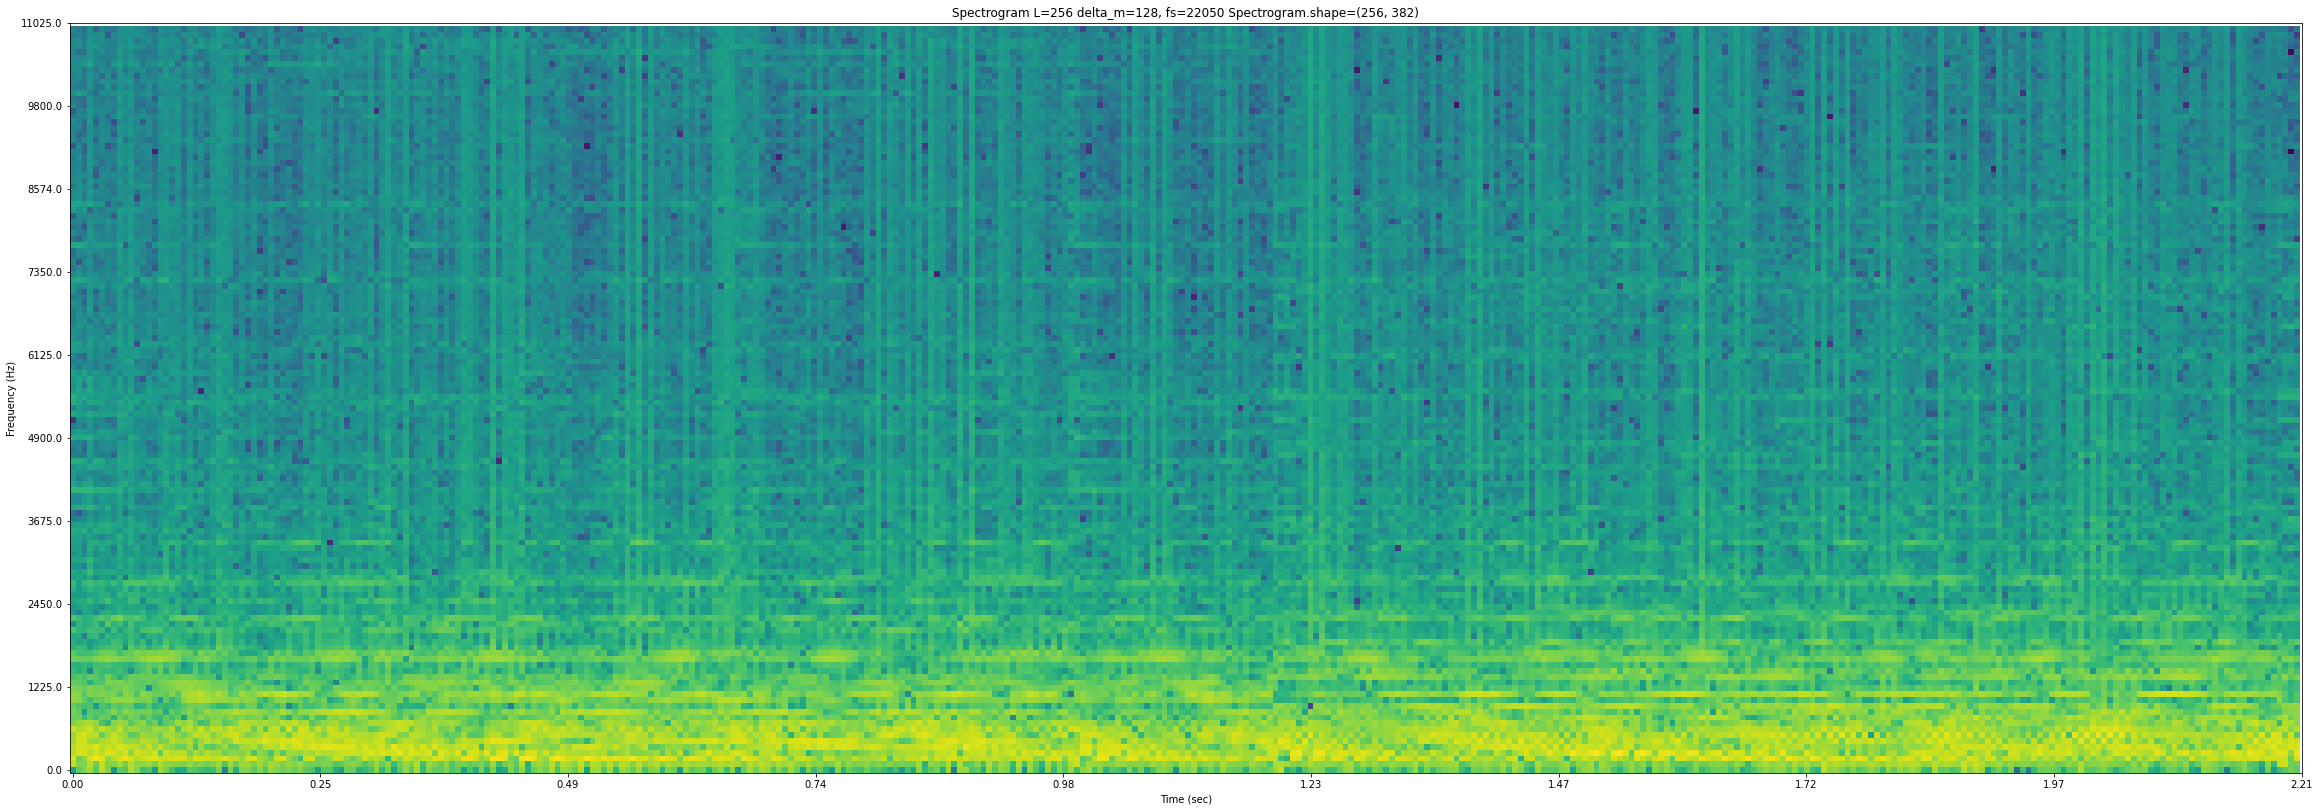

128
(256,)
12928
(256,)
25728
(256,)
38528
(256,)


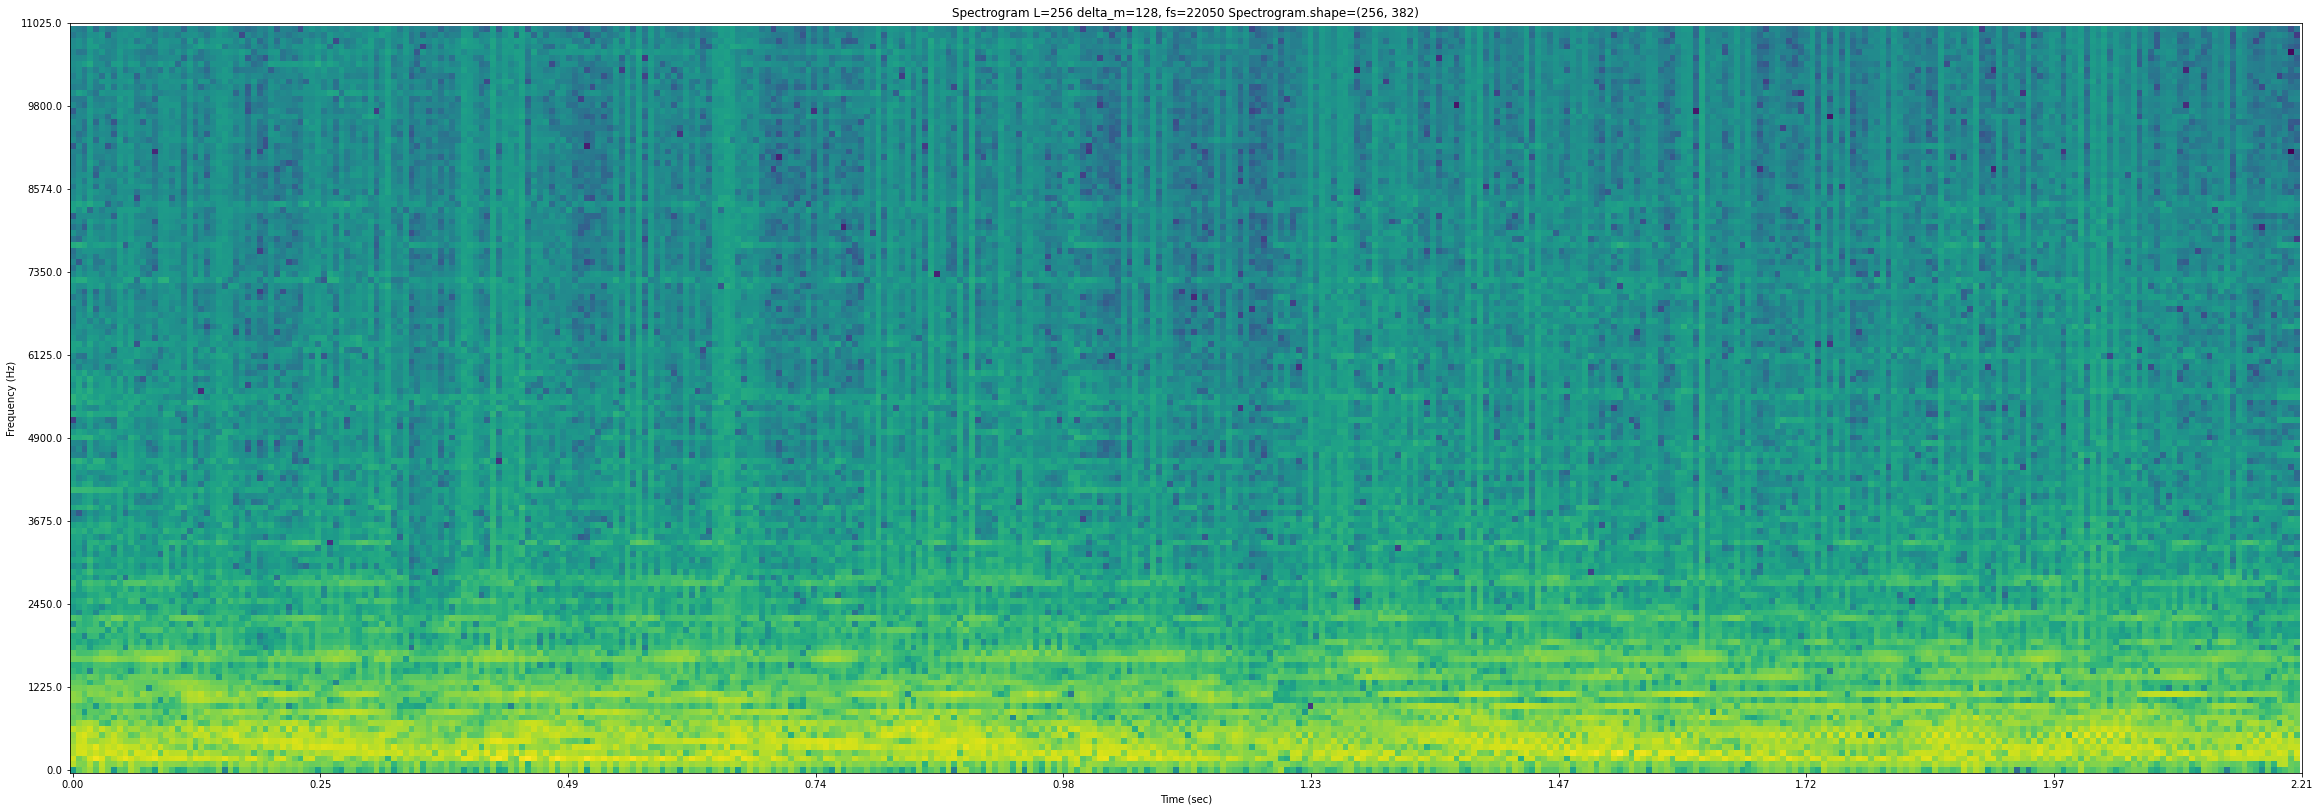

128
(256,)
12928
(256,)
25728
(256,)
38528
(256,)


In [4]:
L = 256
delta_m = 128
freq_spec = np.arange(L)*fs/L


ms, modulator_stft = get_stft(modulator, L, delta_m)
plot_spectrogram(ms, modulator_stft, fs)

ms, carrier_stft = get_stft(carrier, L, delta_m)
plot_spectrogram(ms, carrier_stft, fs)

ms, cross_synth_stft, cross_synth_audio = cross_synthesize(carrier, modulator, L, delta_m)
plot_spectrogram(ms, cross_synth_stft, fs)

r_mod = get_istft(modulator_stft, delta_m)

In [9]:
print(cross_synth_audio)
Audio(cross_synth_audio, rate=fs)

[ 4.3720417 -1.77635684e-15j 10.77435565-5.77315973e-15j
 11.7383695 +8.88178420e-16j ...  2.31640051-3.10862447e-15j
  6.64012204+2.22044605e-15j  7.25491379+1.15463195e-14j]


/Users/Andrew/miniconda3/lib/python3.8/site-packages/IPython/lib/display.py:157: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


In [72]:
print(np.max(carrier))
print(carrier)
Audio(carrier, rate=fs)


32750
[1005 3016 3554 ... 2561 3414 3550]


In [76]:
r_mod = get_istft(modulator_stft, delta_m)

print(r_mod.real)
print(r_mod.shape)
print(modulator_stft.shape)

Audio(r_mod, rate=fs)


128
(256,)
12928
(256,)
25728
(256,)
38528
(256,)
[-1.33984375 -1.2734375  -1.48828125 ... -2.2421875  -2.39453125
 -2.125     ]
(49152,)
(256, 382)


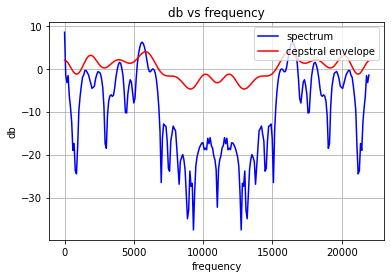

In [8]:
'''
To obtain cepstral coefficients:
signal multiplied by lowpass window: 
    1 -> n < n_c 
    0.5 -> 1 = n_c
    0 -> n > n_c
DFT of signal
log of absolute value of DFT 
'''

L = 256
delta_m = 128
w = np.concatenate([np.ones(L//16), np.zeros(15*L//16)])
freq_spec = np.arange(L)*fs/L

# speech = apply_hamming(carrier)
speech = modulator

speech_spectrum_window = np.fft.fft(speech[:L])
spectrum_amplitudes = 20. * np.log10(1/(100*L) * np.abs( speech_spectrum_window ) )
# spectrum_amplitudes = 20. * np.log10( np.abs( speech_spectrum_window ) )
# cepstral_envelope = (np.fft.ifft(spectrum_amplitudes)).real
spectral_envelope = np.fft.fft(w * np.fft.ifft(np.log10(np.abs(speech_spectrum_window))).real).real
spectral_envelope = spectral_envelope - np.mean(spectral_envelope)

plt.plot(freq_spec, spectrum_amplitudes, color = "blue", label = "spectrum")
plt.plot(freq_spec, 10*spectral_envelope, color = "red", label = "cepstral envelope")
plt.grid()
plt.legend(loc = 'upper right')
plt.title("db vs frequency")
plt.xlabel("frequency")
plt.ylabel("db")
plt.show()

<ipython-input-113-fd9b3830ca1e>:27: RuntimeWarning: divide by zero encountered in log10
  stft_db = 20*np.log10(np.abs(stft[:L//2, :])*2)


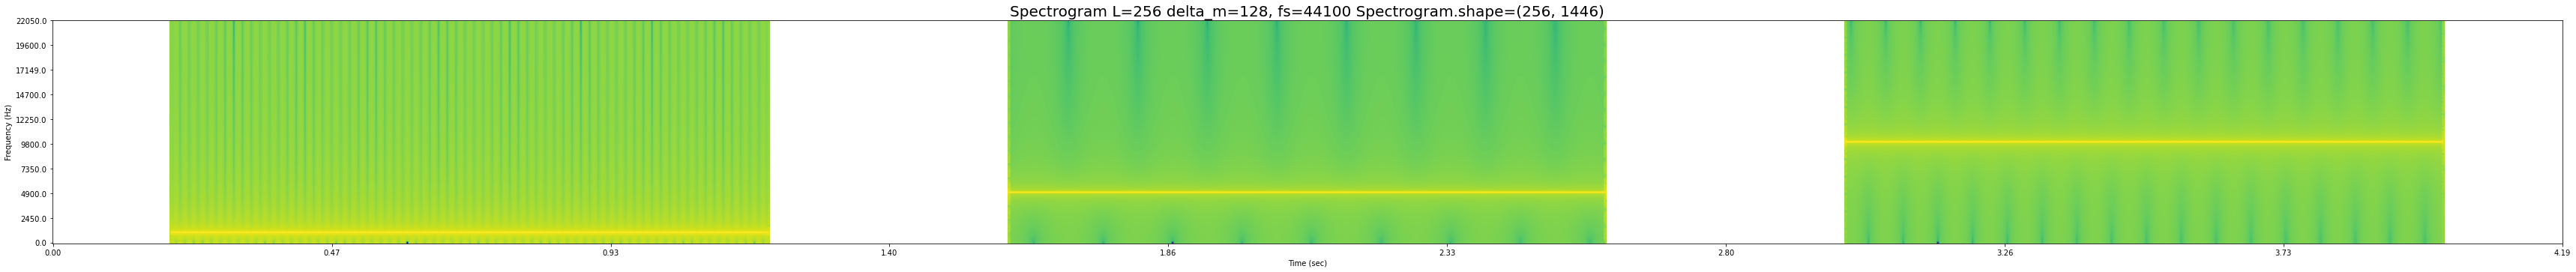

<ipython-input-113-fd9b3830ca1e>:27: RuntimeWarning: divide by zero encountered in log10
  stft_db = 20*np.log10(np.abs(stft[:L//2, :])*2)


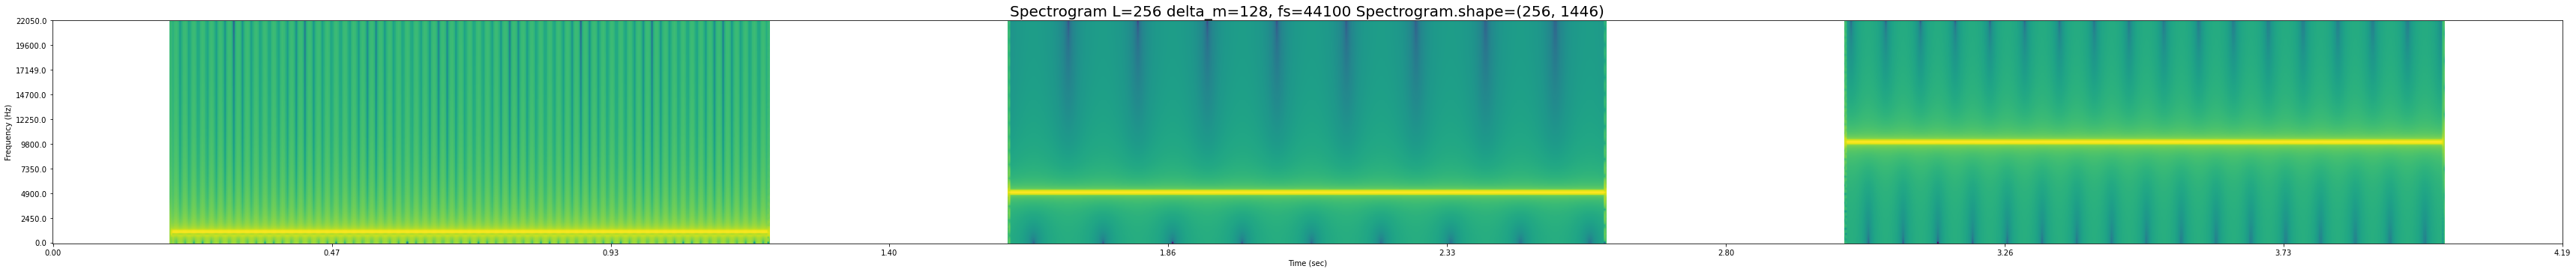